In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) #transform 2D 28x28 matrix to 3D (28x28x1) matrix
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255 #inputs have to be between [0, 1]
x_test /= 255

In [4]:
model = Sequential()

#1st convolution layer
model.add(Conv2D(16, (3, 3) #16 is number of filters and (3, 3) is the size of the filter.
    , padding='same', input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#2nd convolution layer
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#-------------------------

#3rd convolution layer
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#4rd convolution layer
model.add(Conv2D(16,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#-------------------------

model.add(Conv2D(1,(3, 3), padding='same'))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 2)         290       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 2)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 2)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 2)           38        
__________

In [5]:
model.compile(optimizer='adadelta', loss='binary_crossentropy')

model.fit(x_train, x_train
    , epochs=3
    , validation_data=(x_test, x_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 93s 2ms/step - loss: 0.1378 - val_loss: 0.1055
Epoch 2/3
60000/60000 [==============================] - 95s 2ms/step - loss: 0.1017 - val_loss: 0.1000
Epoch 3/3
60000/60000 [==============================] - 99s 2ms/step - loss: 0.0968 - val_loss: 0.0926


In [6]:
restored_imgs = model.predict(x_test)

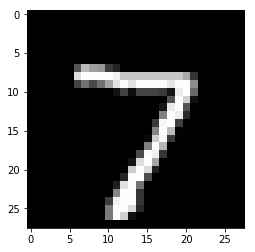

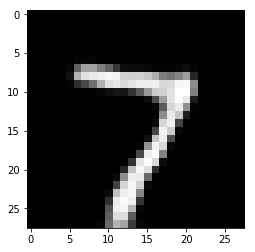

----------------------------


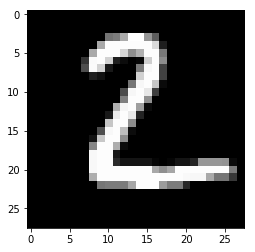

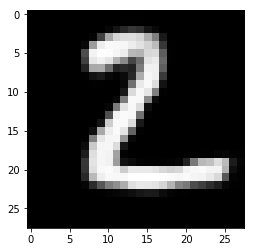

----------------------------


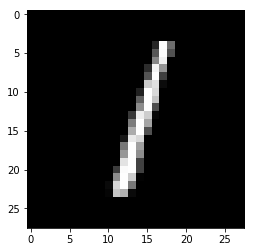

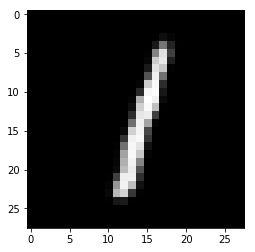

----------------------------


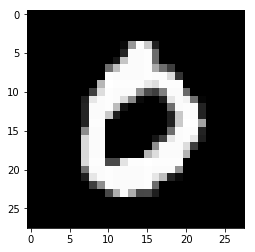

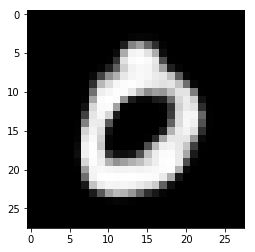

----------------------------


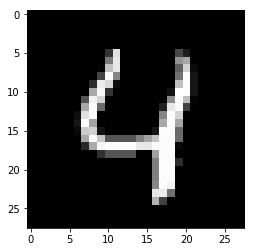

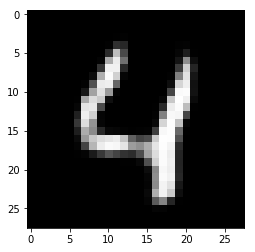

----------------------------


In [7]:
for i in range(5):
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    plt.show()
    
    plt.imshow(restored_imgs[i].reshape(28, 28))
    plt.gray()
    plt.show()
    
    print("----------------------------")

In [8]:
layers = len(model.layers)

for i in range(layers):
    print(i, ". ", model.layers[i].output.get_shape())

0 .  (?, 28, 28, 16)
1 .  (?, 28, 28, 16)
2 .  (?, 14, 14, 16)
3 .  (?, 14, 14, 2)
4 .  (?, 14, 14, 2)
5 .  (?, 7, 7, 2)
6 .  (?, 7, 7, 2)
7 .  (?, 7, 7, 2)
8 .  (?, 14, 14, 2)
9 .  (?, 14, 14, 16)
10 .  (?, 14, 14, 16)
11 .  (?, 28, 28, 16)
12 .  (?, 28, 28, 1)
13 .  (?, 28, 28, 1)


In [9]:
#layer[7] is activation_3 (Activation), it is compressed representation
get_3rd_layer_output = K.function([model.layers[0].input], [model.layers[7].output])
compressed = get_3rd_layer_output([x_test])[0]

In [10]:
#layer[7] is size of (None, 7, 7, 2). this means 2 different 7x7 sized matrixes. We will flatten these matrixes.
compressed = compressed.reshape(10000,7*7*2)

In [12]:
from tensorflow.contrib.factorization.python.ops import clustering_ops
import tensorflow as tf

In [13]:
unsupervised_model = tf.contrib.learn.KMeansClustering(
    10 #num of clusters
    , distance_metric = clustering_ops.SQUARED_EUCLIDEAN_DISTANCE
    , initial_clusters=tf.contrib.learn.KMeansClustering.RANDOM_INIT
)

Instructions for updating:
Please use tf.contrib.factorization.KMeansClustering instead of tf.contrib.learn.KMeansClustering. It has a similar interface, but uses the tf.estimator.Estimator API instead of tf.contrib.learn.Estimator.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_tf_random_seed': None, '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_type': None, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001ABB3D170B8>, '_environment': 'local', '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_num_ps_replicas': 0, '_session_config': None, '_model_dir': 'C:\\Users\\IS96273\\AppData\\Local\\Temp\\tmp0yqpstfv', '_num_worker_replicas': 0, '_task_id': 0}


In [14]:
def train_input_fn():
    data = tf.constant(compressed, tf.float32)
    return (data, None)

In [15]:
unsupervised_model.fit(input_fn=train_input_fn, steps=1000)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\IS96273\AppData\Local\Temp\tmp0yqpstfv\model.ckpt.
INFO:tensorflow:step = 1, loss = 135367.0
INFO:tensorflow:global_step/sec: 172.736
INFO:tensorflow:step = 101, loss = 77365.0 (0.581 sec)
INFO:tensorflow:global_step/sec: 347.942
INFO:tensorflow:step = 201, loss = 77066.8 (0.287 sec)
INFO:tensorflow:global_step/sec: 346.51
INFO:tensorflow:step = 301, loss = 76946.8 (0.288 sec)
INFO:tensorflow:global_step/sec: 288.412
INFO:tensorflow:step = 401, loss = 76875.8 (0.348 sec)
INFO:tensorflow:global_step/sec: 294.093
INFO:tensorflow:step = 501, loss = 76829.3 (0.338 sec)
INFO:tensorflow:global_step/sec: 302.266
INFO:tensorflow:step = 601, loss = 76795.9 (0.332 sec)
INFO:tensorflow:global_step/sec: 342.49


KMeansClustering(params={'distance_metric': 'squared_euclidean', 'num_clusters': 10, 'kmeans_plus_plus_num_retries': 2, 'mini_batch_steps_per_iteration': 1, 'training_initial_clusters': 'random', 'use_mini_batch': True, 'random_seed': 0, 'relative_tolerance': None})

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\IS96273\AppData\Local\Temp\tmp0yqpstfv\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


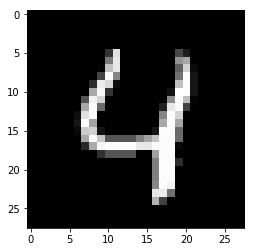

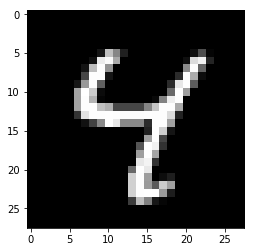

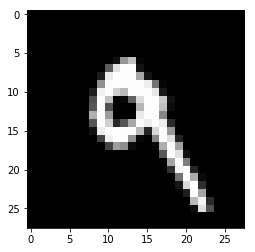

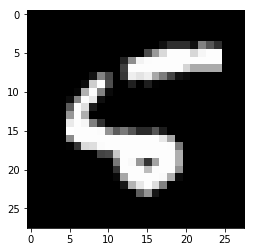

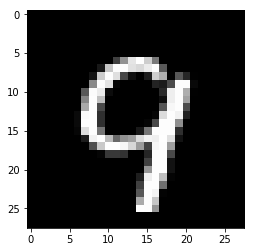

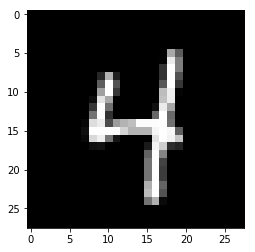

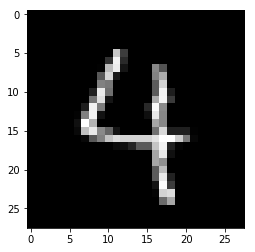

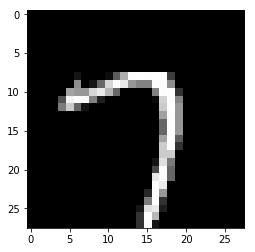

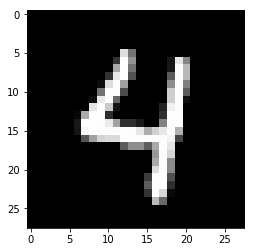

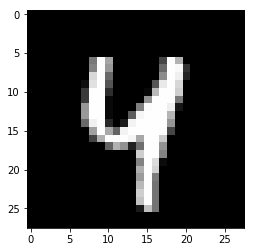

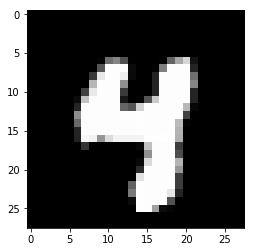

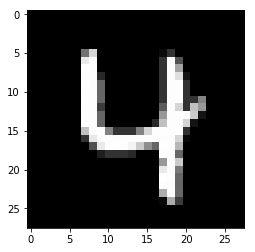

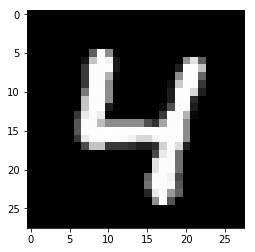

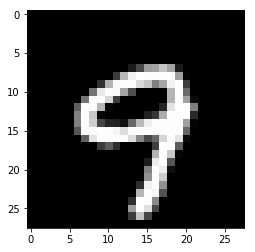

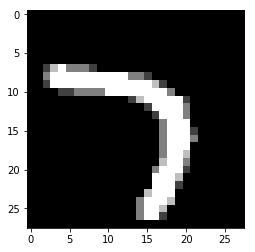

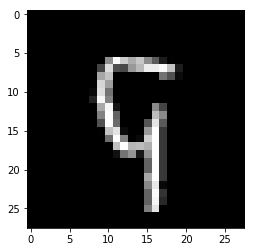

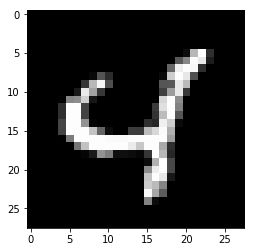

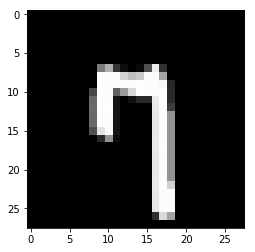

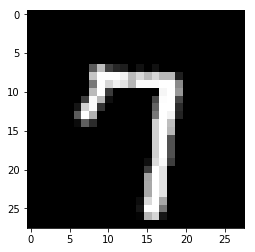

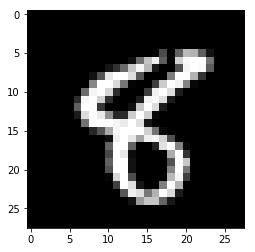

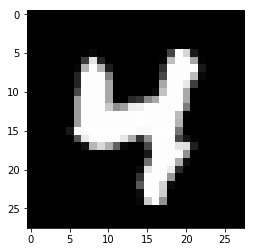

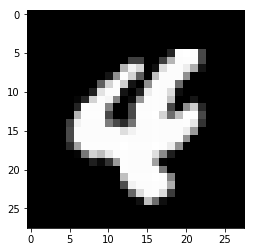

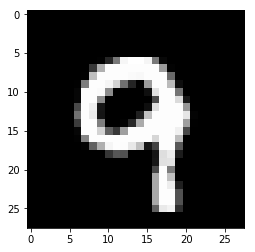

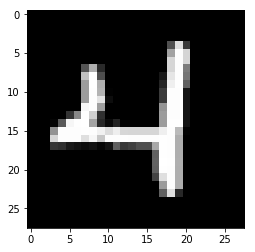

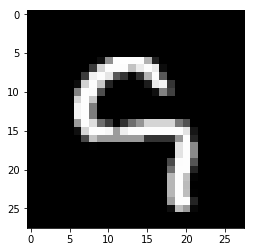

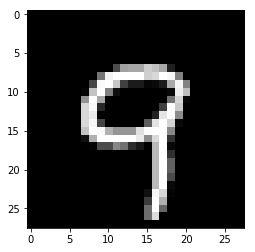

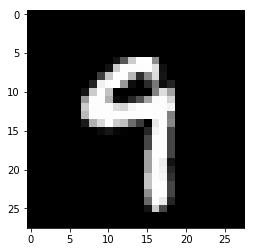

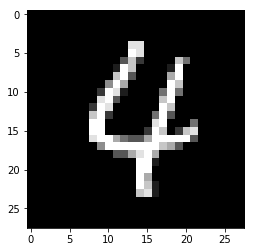

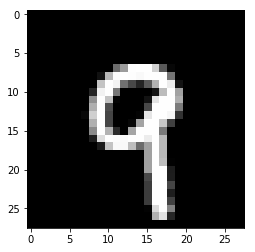

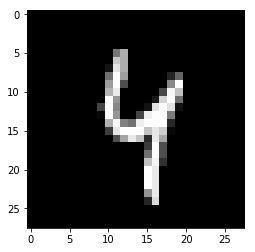

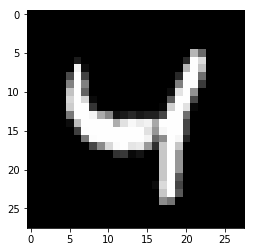

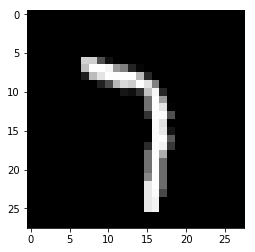

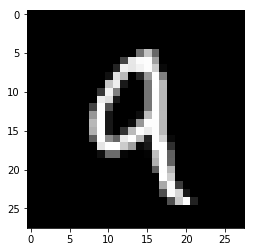

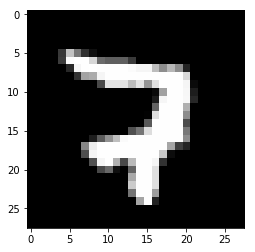

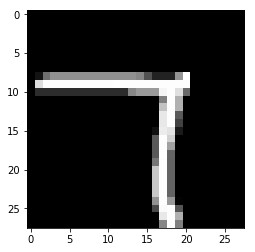

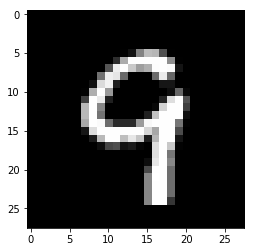

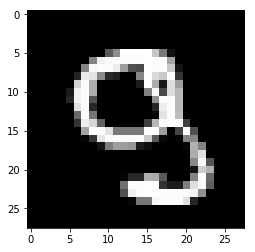

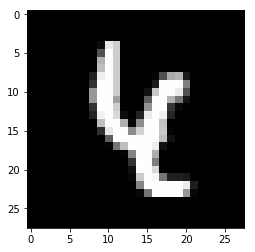

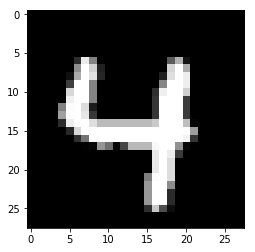

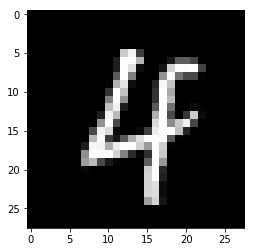

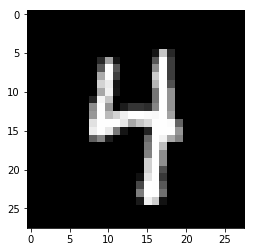

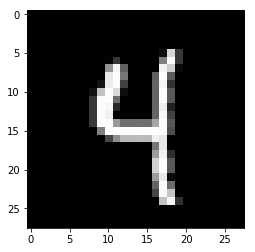

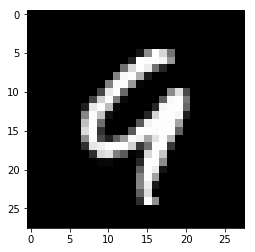

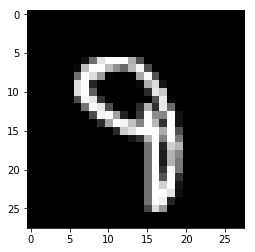

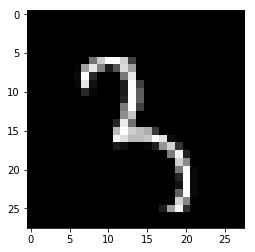

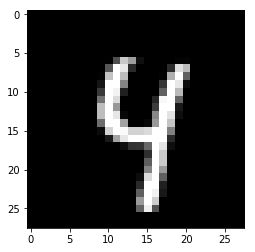

In [16]:
clusters = unsupervised_model.predict(input_fn=train_input_fn)

index = 0
for i in clusters:
    current_cluster = i['cluster_idx']
    features = x_test[index]
    
    if index < 200 and current_cluster == 5:
        plt.imshow(x_test[index].reshape(28, 28))
        plt.gray()
        plt.show()
    index = index + 1